In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [26]:
data = pd.read_csv('data/fake_job_postings.csv')
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [27]:
data.shape

(17880, 18)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

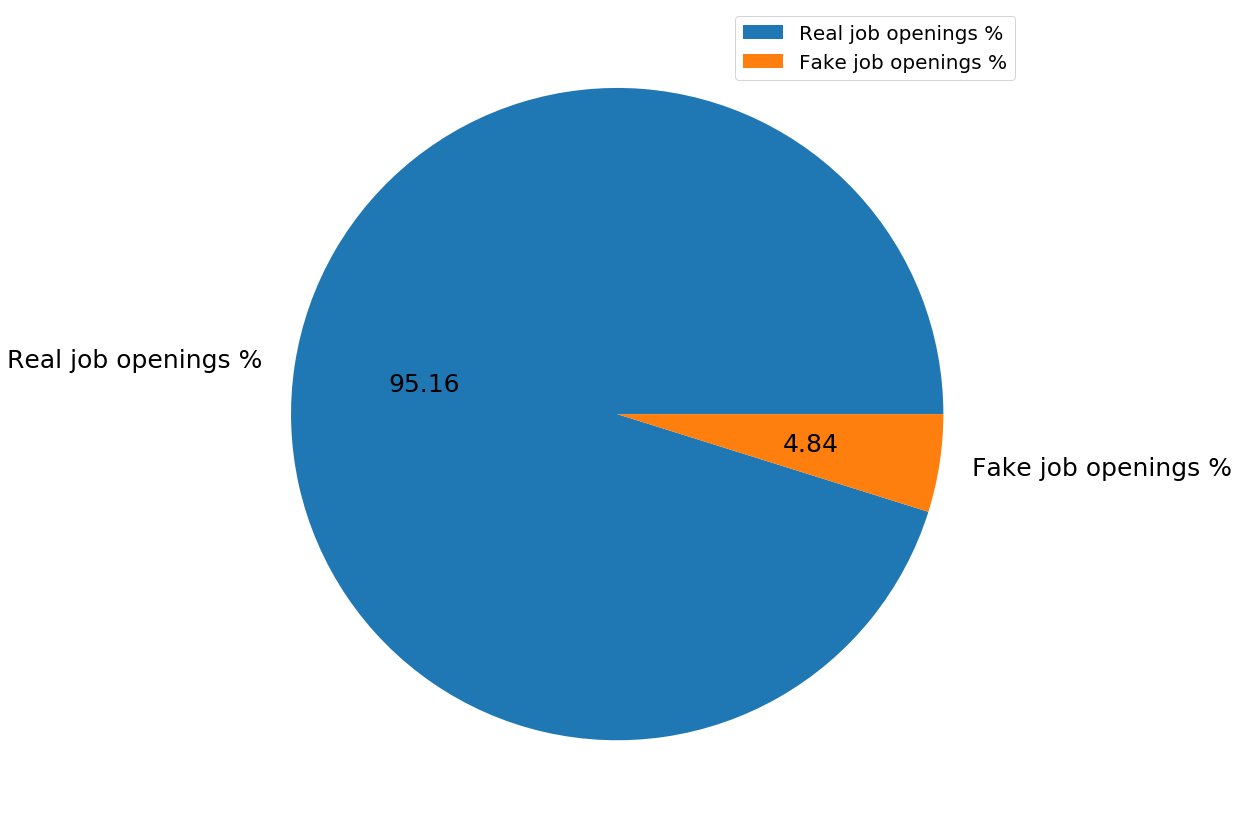

In [28]:
fraud = data['fraudulent'].value_counts()
labels_jobs = 'Real job openings %', 'Fake job openings %'
plt.figure(figsize=(20,15))
plt.pie(fraud, labels = labels_jobs, autopct='%1.2f', textprops={'fontsize': 25})
plt.legend(prop={'size': 20})

### Around 5% of the job openings are fake. Now this data represents the entire population is another question as this data is mostly from the United States and demographics affects the nature of job openings a lot.

### There are many NaN values in the data. We need to fill them with a value before we perform EDA.

In [29]:
columns=['location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits',
        'employment_type', 'required_experience', 'required_education', 'industry', 'function']

In [30]:
for col in columns:
    nan_count = data[col].isnull().sum()
    if nan_count > 0:
        data[col].fillna('unknown', inplace=True)

### How many fraudulent jobs do we have in our training data?

In [31]:
data['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

### We have 866 fraudulent jobs. There is a class imbalance which we have to keep in mind while fitting a model.

In [32]:
data['title'] = data['title'].replace({'English Teacher Abroad ': 'English Teacher Abroad'})

### The job location is comma seperated as country code, city code, city name. We can separate them into two columns as 'country code' and 'city name'

In [33]:
data_location = data['location'].str.split(',',expand=True)

In [34]:
data['country_code'] = data_location[0]
data['city_name'] = data_location[2]

In [35]:
data.drop('location', axis=1, inplace=True)

In [36]:
data['country_code'].isnull().sum()

0

In [37]:
data['city_name'].isnull().sum()

440

In [38]:
data['city_name'].fillna('unknown', inplace=True)

In [39]:
data['city_name'] = data['city_name'].replace({' ': 'unknown'})

### For performing EDA, removing the fake job postings from the data temporarily.

In [40]:
real_jobs = data[data['fraudulent'] == 0]

In [41]:
real_jobs.shape

(17014, 19)

In [42]:
real_jobs['title'].nunique()

10729

### There are 10729 unique job titles

### What are some of the job openings that had the highest vacancy?

In [43]:
def plot_horizontal(df, col_name, title, top=10):
    new_df = df[df[col_name] != 'unknown']
    job_col = new_df[col_name].value_counts().rename_axis(col_name).reset_index(name='Count')
    top_count = job_col.sort_values('Count', ascending=False)[:top]
    ax = top_count.plot.barh(x=col_name, y='Count',figsize=(15,8), title=title)
    ax.invert_yaxis()

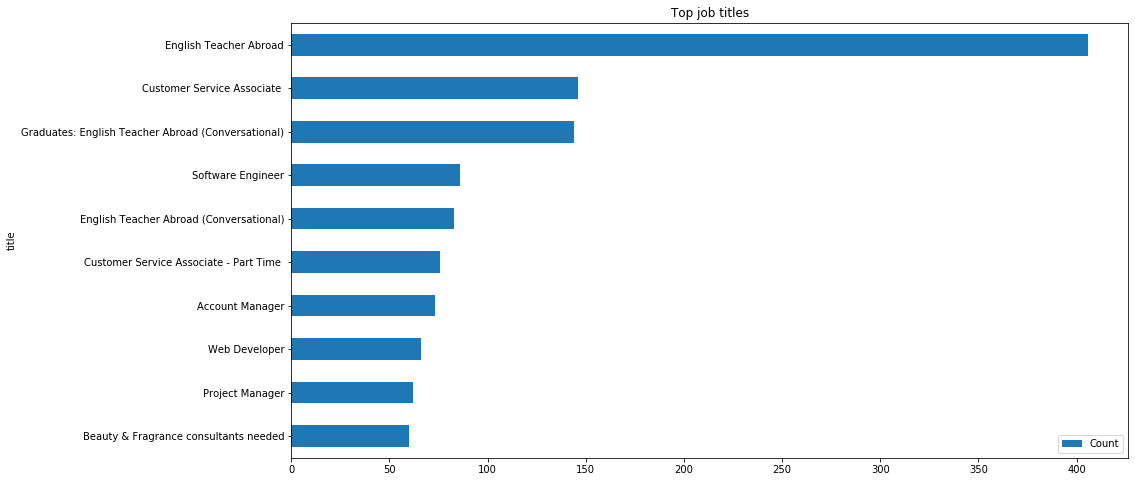

In [44]:
plot_horizontal(real_jobs, 'title', 'Top job titles')

### Which countries and cities had the highest job openings?

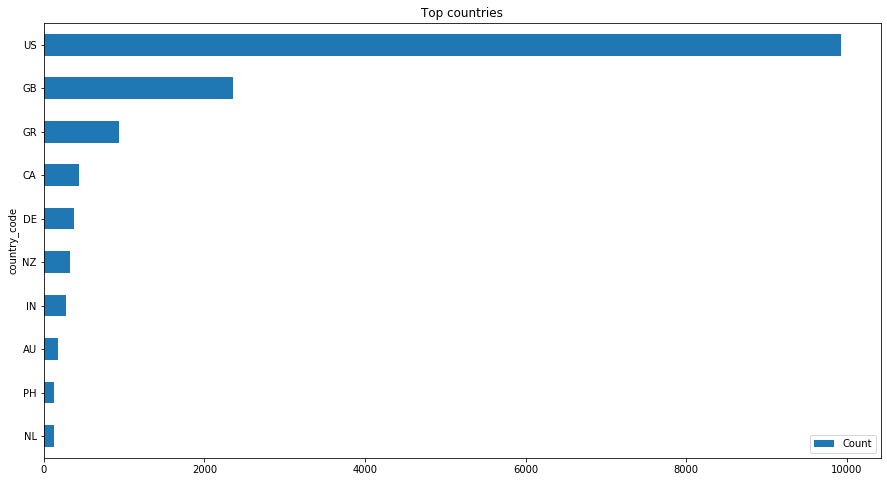

In [46]:
plot_horizontal(real_jobs, 'country_code', 'Top countries')

### US has the highest number of openings followed by United Kingdom, Greece, Canada, Germany and so on...

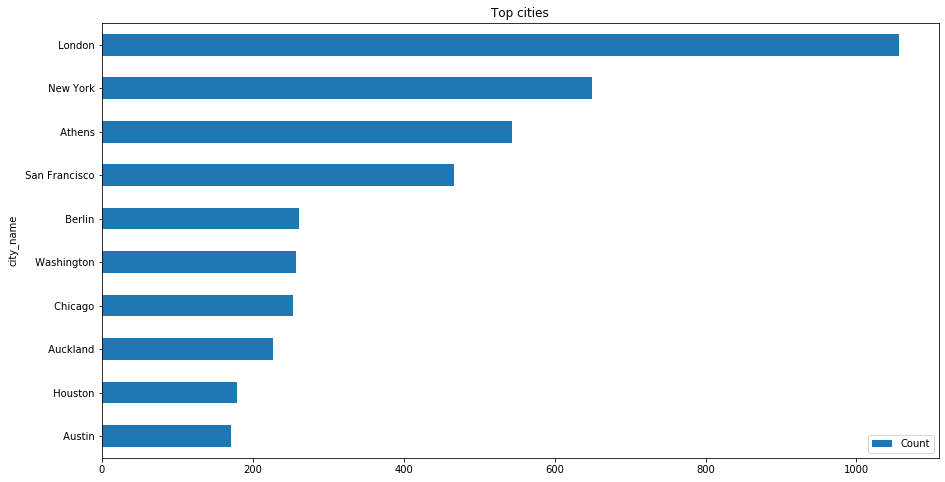

In [47]:
plot_horizontal(real_jobs, 'city_name', 'Top cities')

### London had the highest openings followed by New York, Athens, San Francisco, Berlin.....

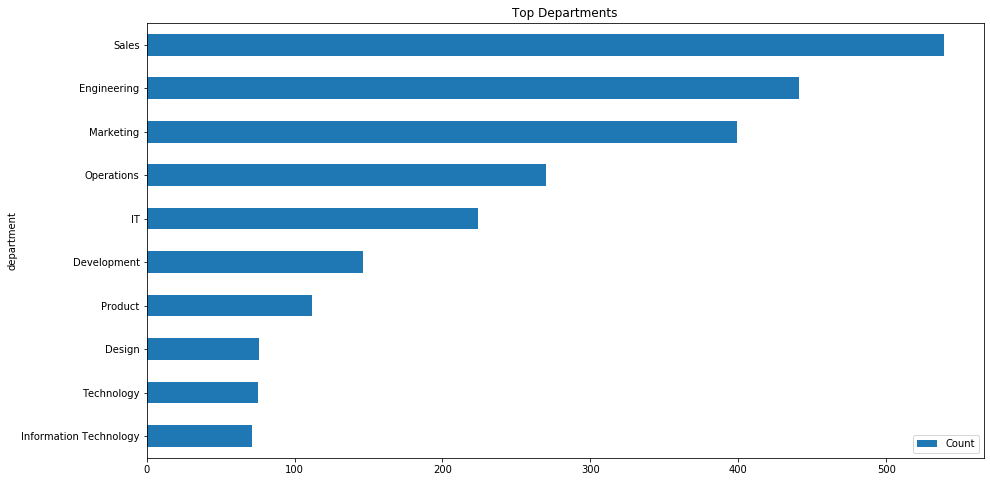

In [48]:
plot_horizontal(real_jobs, 'department', 'Top Departments')

### Above graph shows the top departments for which the job openings were posted. It is important to note though that departments for most of the job openings are unknown to us (around 65% of the openings departments are unknown). This feature is not important to us when we fit a classifier.

### We have 4 features which are text: company_profile, description, requirements and benefits. We can plot word clouds for each of the features to find the top keywords.

In [49]:
#removing special characters
real_jobs['company_profile'] = real_jobs['company_profile'].str.replace('[^\dA-Za-z]', ' ')
real_jobs['description'] = real_jobs['description'].str.replace('[^\dA-Za-z]', ' ')
real_jobs['requirements'] = real_jobs['requirements'].str.replace('[^\dA-Za-z]', ' ')
real_jobs['benefits'] = real_jobs['benefits'].str.replace('[^\dA-Za-z]', ' ')

In [50]:
real_jobs.head()

,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country_code,city_name
0,1,Marketing Intern,Marketing,unknown,We re Food52 and we ve created a groundbreaki...,Food52 a fast growing James Beard Award winn...,Experience with content management systems a m...,unknown,0,1,0,Other,Internship,unknown,unknown,Marketing,0,US,New York
1,2,Customer Service - Cloud Video Production,Success,unknown,90 Seconds the worlds Cloud Video Production ...,Organised Focused Vibrant Awesome Do you...,What we expect from you Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,unknown,Marketing and Advertising,Customer Service,0,NZ,Auckland
2,3,Commissioning Machinery Assistant (CMA),unknown,unknown,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively se...,Implement pre commissioning and commissioning ...,unknown,0,1,0,unknown,unknown,unknown,unknown,unknown,0,US,Wever
3,4,Account Executive - Washington DC,Sales,unknown,Our passion for improving quality of life thro...,THE COMPANY ESRI Environmental Systems Rese...,EDUCATION Bachelor s or Master s in GIS busi...,Our culture is anything but corporate we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Washington
4,5,Bill Review Manager,unknown,unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION ...,QUALIFICATIONS RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth


In [51]:
def custom_tokenize(text):
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return nltk.word_tokenize(text)

In [52]:
#tokenizing the columns to remove stopwords
real_jobs['company_profile_tokenized'] = real_jobs['company_profile'].apply(custom_tokenize)

In [53]:
real_jobs['description_tokenized'] = real_jobs['description'].apply(custom_tokenize)

In [54]:
real_jobs['requirements_tokenized'] = real_jobs['requirements'].apply(custom_tokenize)

In [55]:
real_jobs['benefits_tokenized'] = real_jobs['benefits'].apply(custom_tokenize)

In [56]:
real_jobs.head()

,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,required_education,industry,function,fraudulent,country_code,city_name,company_profile_tokenized,description_tokenized,requirements_tokenized,benefits_tokenized
0,1,Marketing Intern,Marketing,unknown,We re Food52 and we ve created a groundbreaki...,Food52 a fast growing James Beard Award winn...,Experience with content management systems a m...,unknown,0,1,...,unknown,unknown,Marketing,0,US,New York,"[We, re, Food52, and, we, ve, created, a, grou...","[Food52, a, fast, growing, James, Beard, Award...","[Experience, with, content, management, system...",[unknown]
1,2,Customer Service - Cloud Video Production,Success,unknown,90 Seconds the worlds Cloud Video Production ...,Organised Focused Vibrant Awesome Do you...,What we expect from you Your key responsibilit...,What you will get from usThrough being part of...,0,1,...,unknown,Marketing and Advertising,Customer Service,0,NZ,Auckland,"[90, Seconds, the, worlds, Cloud, Video, Produ...","[Organised, Focused, Vibrant, Awesome, Do, you...","[What, we, expect, from, you, Your, key, respo...","[What, you, will, get, from, usThrough, being,..."
2,3,Commissioning Machinery Assistant (CMA),unknown,unknown,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively se...,Implement pre commissioning and commissioning ...,unknown,0,1,...,unknown,unknown,unknown,0,US,Wever,"[Valor, Services, provides, Workforce, Solutio...","[Our, client, located, in, Houston, is, active...","[Implement, pre, commissioning, and, commissio...",[unknown]
3,4,Account Executive - Washington DC,Sales,unknown,Our passion for improving quality of life thro...,THE COMPANY ESRI Environmental Systems Rese...,EDUCATION Bachelor s or Master s in GIS busi...,Our culture is anything but corporate we have ...,0,1,...,Bachelor's Degree,Computer Software,Sales,0,US,Washington,"[Our, passion, for, improving, quality, of, li...","[THE, COMPANY, ESRI, Environmental, Systems, R...","[EDUCATION, Bachelor, s, or, Master, s, in, GI...","[Our, culture, is, anything, but, corporate, w..."
4,5,Bill Review Manager,unknown,unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION ...,QUALIFICATIONS RN license in the State of Texa...,Full Benefits Offered,0,1,...,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth,"[SpotSource, Solutions, LLC, is, a, Global, Hu...","[JOB, TITLE, Itemization, Review, ManagerLOCAT...","[QUALIFICATIONS, RN, license, in, the, State, ...","[Full, Benefits, Offered]"


In [57]:
stop_words = list(set(stopwords.words('english')))+list(punctuation)+['``', "'s", "...", "n't", 'unknown']

In [58]:
# stopword removal
real_jobs['company_profile_tokenized'] = real_jobs['company_profile_tokenized'].apply(lambda row: [word for word in row if word not in stop_words])
real_jobs['description_tokenized'] = real_jobs['description_tokenized'].apply(lambda row: [word for word in row if word not in stop_words])
real_jobs['requirements_tokenized'] = real_jobs['requirements_tokenized'].apply(lambda row: [word for word in row if word not in stop_words])
real_jobs['benefits_tokenized'] = real_jobs['benefits_tokenized'].apply(lambda row: [word for word in row if word not in stop_words])

In [59]:
real_jobs.head()

,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,required_education,industry,function,fraudulent,country_code,city_name,company_profile_tokenized,description_tokenized,requirements_tokenized,benefits_tokenized
0,1,Marketing Intern,Marketing,unknown,We re Food52 and we ve created a groundbreaki...,Food52 a fast growing James Beard Award winn...,Experience with content management systems a m...,unknown,0,1,...,unknown,unknown,Marketing,0,US,New York,"[We, Food52, created, groundbreaking, award, w...","[Food52, fast, growing, James, Beard, Award, w...","[Experience, content, management, systems, maj...",[]
1,2,Customer Service - Cloud Video Production,Success,unknown,90 Seconds the worlds Cloud Video Production ...,Organised Focused Vibrant Awesome Do you...,What we expect from you Your key responsibilit...,What you will get from usThrough being part of...,0,1,...,unknown,Marketing and Advertising,Customer Service,0,NZ,Auckland,"[90, Seconds, worlds, Cloud, Video, Production...","[Organised, Focused, Vibrant, Awesome, Do, pas...","[What, expect, Your, key, responsibility, comm...","[What, get, usThrough, part, 90, Seconds, team..."
2,3,Commissioning Machinery Assistant (CMA),unknown,unknown,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively se...,Implement pre commissioning and commissioning ...,unknown,0,1,...,unknown,unknown,unknown,0,US,Wever,"[Valor, Services, provides, Workforce, Solutio...","[Our, client, located, Houston, actively, seek...","[Implement, pre, commissioning, commissioning,...",[]
3,4,Account Executive - Washington DC,Sales,unknown,Our passion for improving quality of life thro...,THE COMPANY ESRI Environmental Systems Rese...,EDUCATION Bachelor s or Master s in GIS busi...,Our culture is anything but corporate we have ...,0,1,...,Bachelor's Degree,Computer Software,Sales,0,US,Washington,"[Our, passion, improving, quality, life, geogr...","[THE, COMPANY, ESRI, Environmental, Systems, R...","[EDUCATION, Bachelor, Master, GIS, business, a...","[Our, culture, anything, corporate, collaborat..."
4,5,Bill Review Manager,unknown,unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION ...,QUALIFICATIONS RN license in the State of Texa...,Full Benefits Offered,0,1,...,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth,"[SpotSource, Solutions, LLC, Global, Human, Ca...","[JOB, TITLE, Itemization, Review, ManagerLOCAT...","[QUALIFICATIONS, RN, license, State, TexasDipl...","[Full, Benefits, Offered]"


In [60]:
def generate_wordcloud(dataframe, col_name, title):
    
    wordcloud = WordCloud().generate(dataframe[col_name].to_string())

    # Display the generated image:
    plt.figure(figsize=(15,8))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

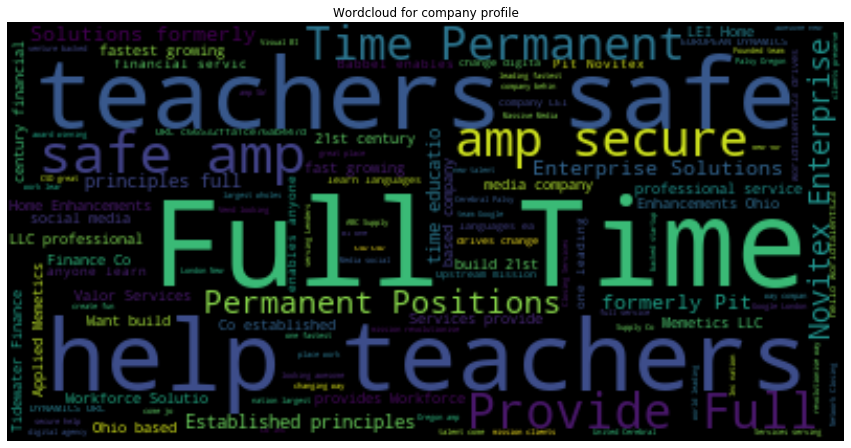

In [61]:
generate_wordcloud(real_jobs, 'company_profile_tokenized', 'Wordcloud for company profile')

### For company profile, the top keywords are 'Full Time', 'help teachers', 'Provide Full' , etc...

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

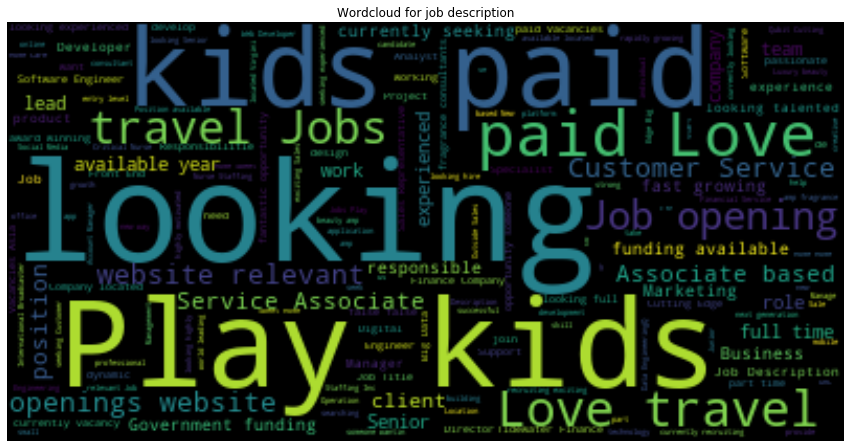

In [62]:
generate_wordcloud(real_jobs, 'description_tokenized', 'Wordcloud for job description')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

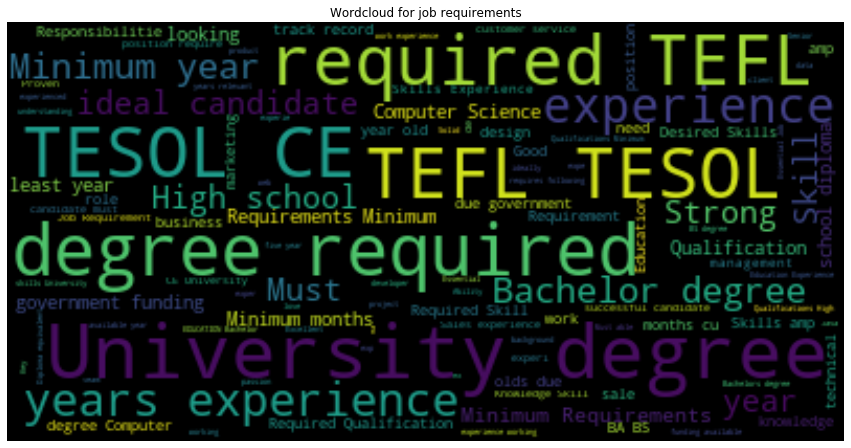

In [63]:
generate_wordcloud(real_jobs, 'requirements_tokenized', 'Wordcloud for job requirements')

### Some of the top requirements are University degree, TEFL and TESOL certifications. TEFL (Teaching English as a Foreign Language) and TESOL (Teaching English to Speakers of Other Languages) are certifications that are required for English teachers in non-english speaking countries.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

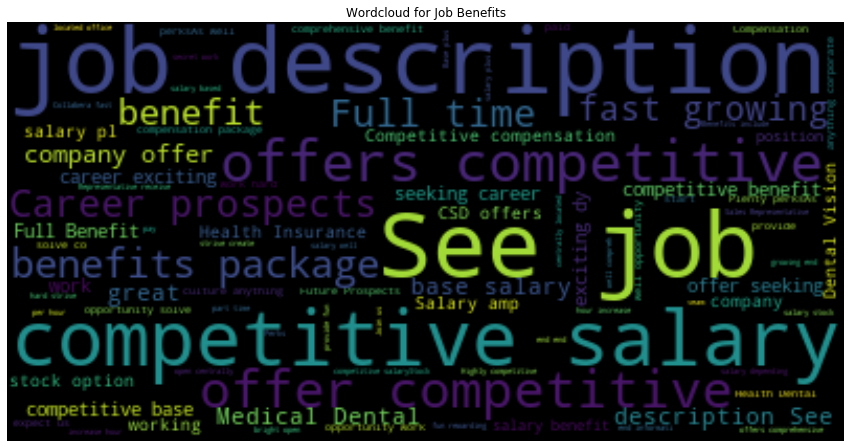

In [64]:
generate_wordcloud(real_jobs, 'benefits_tokenized', 'Wordcloud for Job Benefits')

### 'competitive salary' is one of the top benefits offered in the job openings.

In [65]:
real_jobs.head()

,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,required_education,industry,function,fraudulent,country_code,city_name,company_profile_tokenized,description_tokenized,requirements_tokenized,benefits_tokenized
0,1,Marketing Intern,Marketing,unknown,We re Food52 and we ve created a groundbreaki...,Food52 a fast growing James Beard Award winn...,Experience with content management systems a m...,unknown,0,1,...,unknown,unknown,Marketing,0,US,New York,"[We, Food52, created, groundbreaking, award, w...","[Food52, fast, growing, James, Beard, Award, w...","[Experience, content, management, systems, maj...",[]
1,2,Customer Service - Cloud Video Production,Success,unknown,90 Seconds the worlds Cloud Video Production ...,Organised Focused Vibrant Awesome Do you...,What we expect from you Your key responsibilit...,What you will get from usThrough being part of...,0,1,...,unknown,Marketing and Advertising,Customer Service,0,NZ,Auckland,"[90, Seconds, worlds, Cloud, Video, Production...","[Organised, Focused, Vibrant, Awesome, Do, pas...","[What, expect, Your, key, responsibility, comm...","[What, get, usThrough, part, 90, Seconds, team..."
2,3,Commissioning Machinery Assistant (CMA),unknown,unknown,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively se...,Implement pre commissioning and commissioning ...,unknown,0,1,...,unknown,unknown,unknown,0,US,Wever,"[Valor, Services, provides, Workforce, Solutio...","[Our, client, located, Houston, actively, seek...","[Implement, pre, commissioning, commissioning,...",[]
3,4,Account Executive - Washington DC,Sales,unknown,Our passion for improving quality of life thro...,THE COMPANY ESRI Environmental Systems Rese...,EDUCATION Bachelor s or Master s in GIS busi...,Our culture is anything but corporate we have ...,0,1,...,Bachelor's Degree,Computer Software,Sales,0,US,Washington,"[Our, passion, improving, quality, life, geogr...","[THE, COMPANY, ESRI, Environmental, Systems, R...","[EDUCATION, Bachelor, Master, GIS, business, a...","[Our, culture, anything, corporate, collaborat..."
4,5,Bill Review Manager,unknown,unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION ...,QUALIFICATIONS RN license in the State of Texa...,Full Benefits Offered,0,1,...,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth,"[SpotSource, Solutions, LLC, Global, Human, Ca...","[JOB, TITLE, Itemization, Review, ManagerLOCAT...","[QUALIFICATIONS, RN, license, State, TexasDipl...","[Full, Benefits, Offered]"


In [66]:
real_jobs.columns

Index(['job_id', 'title', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'country_code', 'city_name', 'company_profile_tokenized',
       'description_tokenized', 'requirements_tokenized',
       'benefits_tokenized'],
      dtype='object')

In [67]:
real_jobs['telecommuting'].value_counts()

0    16311
1      703
Name: telecommuting, dtype: int64

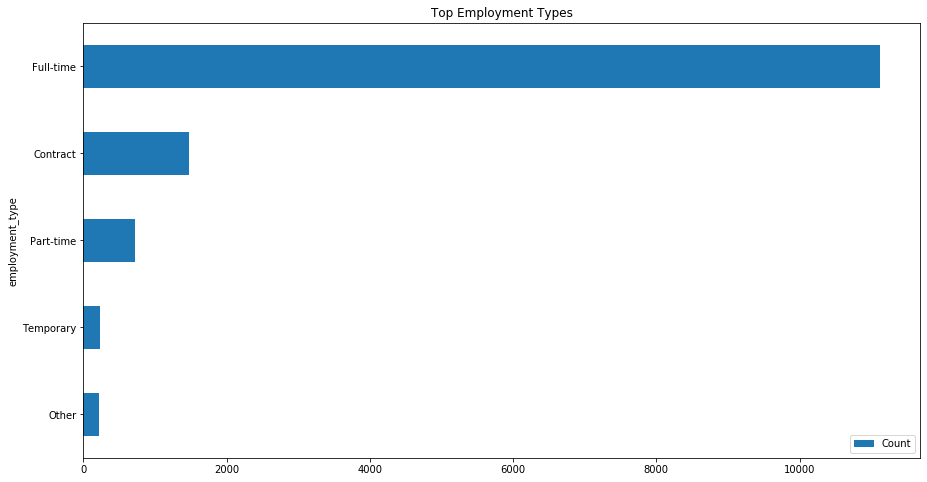

In [68]:
plot_horizontal(real_jobs, 'employment_type', 'Top Employment Types')

### Most of the jobs offered are full-time

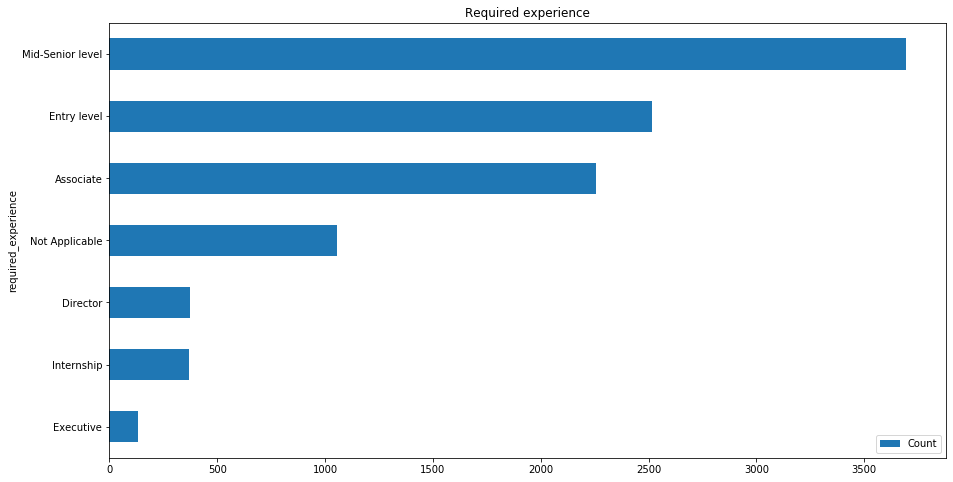

In [69]:
plot_horizontal(real_jobs, 'required_experience', 'Required experience')

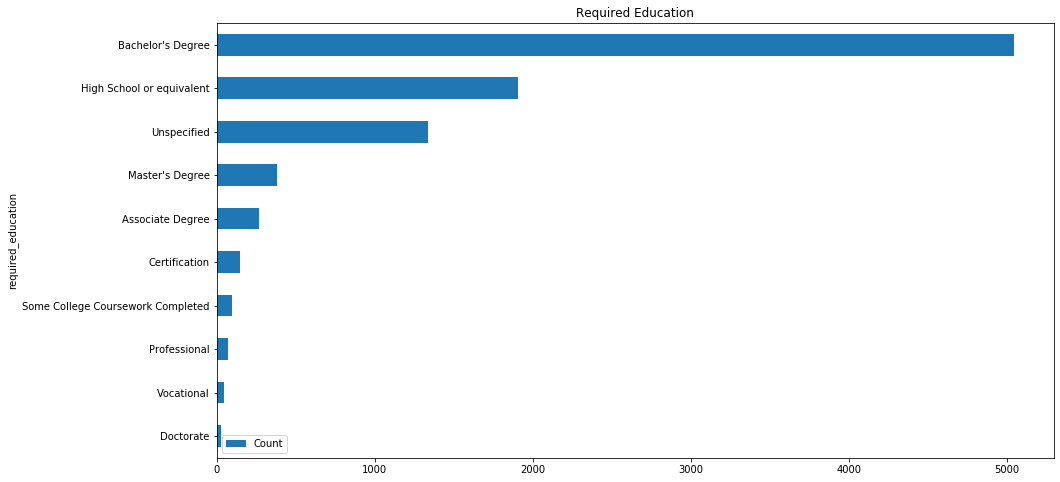

In [70]:
plot_horizontal(real_jobs, 'required_education', 'Required Education')

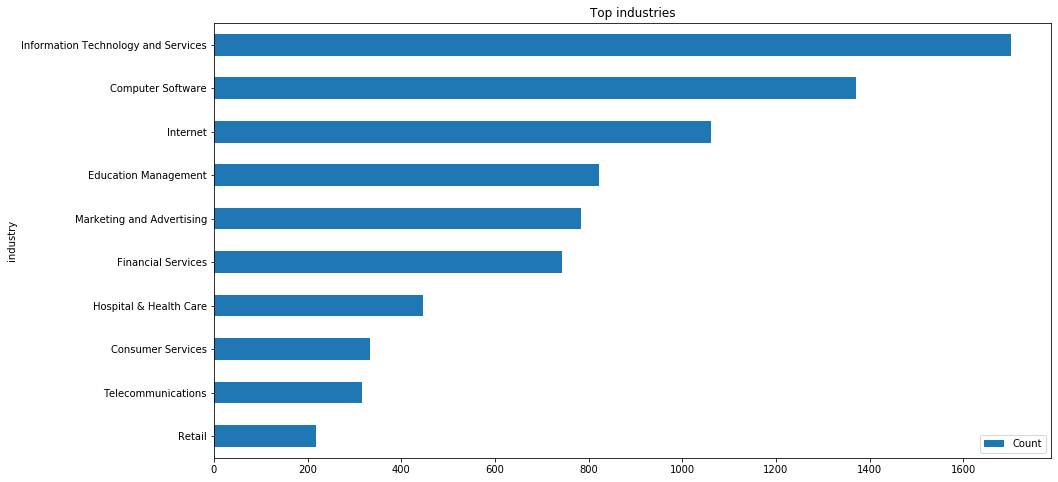

In [71]:
plot_horizontal(real_jobs, 'industry', 'Top industries')

### We can do a separate EDA on fake jobs to find out any unique characteristics fake job openings have

In [72]:
fake_jobs = data[data['fraudulent'] == 1]

In [73]:
fake_jobs.shape

(866, 19)

In [74]:
fake_jobs.head()

,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country_code,city_name
98,99,IC&E Technician,Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US,Stocton
144,145,Forward Cap.,unknown,unknown,unknown,The group has raised a fund for the purchase o...,unknown,unknown,0,0,0,unknown,unknown,unknown,unknown,unknown,1,unknown,unknown
173,174,Technician Instrument & Controls,Power Plant & Energy,unknown,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1,US,unknown
180,181,Sales Executive,Sales,unknown,unknown,Sales Executive,Sales Executive,Sales Executive,0,0,0,unknown,unknown,unknown,unknown,Sales,1,PK,Karachi
215,216,IC&E Technician Mt Poso,Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abiliti...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US,Bakersfield


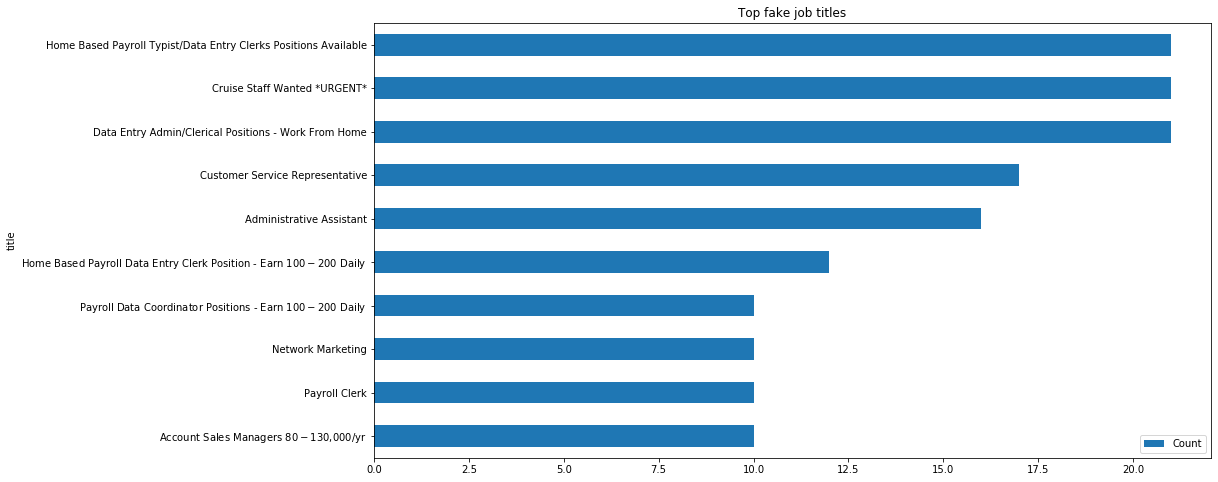

In [75]:
plot_horizontal(fake_jobs, 'title', 'Top fake job titles')

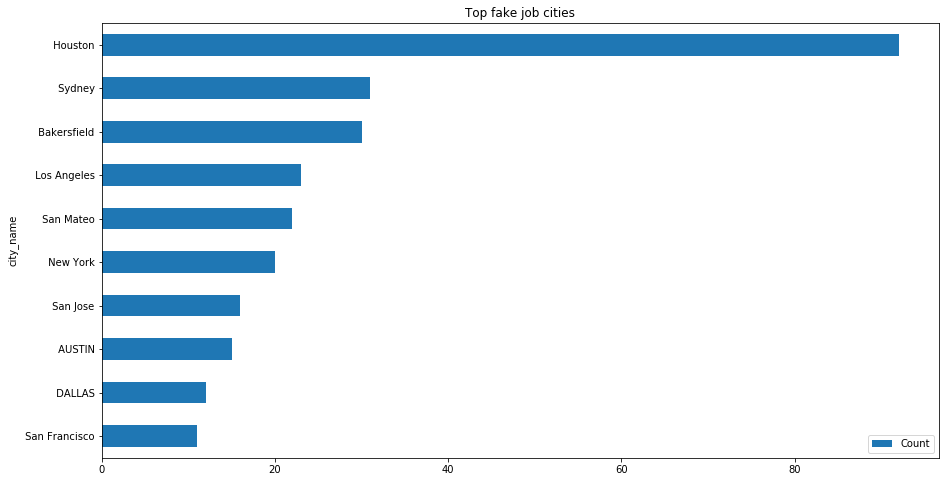

In [76]:
plot_horizontal(fake_jobs, 'city_name', 'Top fake job cities')

### There are a high number of fake job opening for city 'Houston'

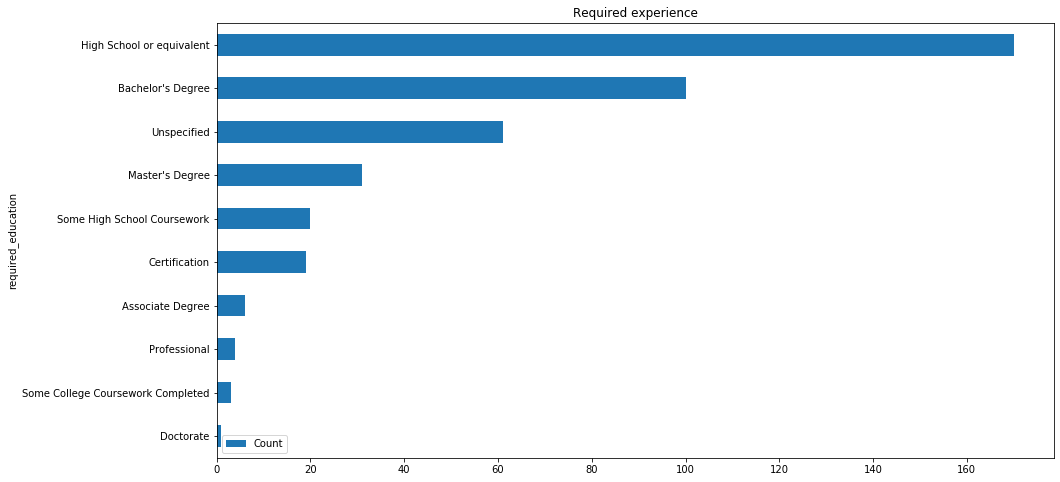

In [77]:
plot_horizontal(fake_jobs, 'required_education', 'Required experience')

### High school passed out students are targeted the highest for a fake job followed by students having a Bachelor's Degree. Also, a high number of fake job openings required education are unspecified.

In [78]:
#removing special characters
fake_jobs['company_profile'] = fake_jobs['company_profile'].str.replace('[^\dA-Za-z]', ' ')
fake_jobs['description'] = fake_jobs['description'].str.replace('[^\dA-Za-z]', ' ')
fake_jobs['requirements'] = fake_jobs['requirements'].str.replace('[^\dA-Za-z]', ' ')
fake_jobs['benefits'] = fake_jobs['benefits'].str.replace('[^\dA-Za-z]', ' ')

In [79]:
fake_jobs['company_profile_tokenized'] = fake_jobs['company_profile'].apply(custom_tokenize)
fake_jobs['description_tokenized'] = fake_jobs['description'].apply(custom_tokenize)
fake_jobs['requirements_tokenized'] = fake_jobs['requirements'].apply(custom_tokenize)
fake_jobs['benefits_tokenized'] = fake_jobs['benefits'].apply(custom_tokenize)

In [80]:
# stopword removal
fake_jobs['company_profile_tokenized'] = fake_jobs['company_profile_tokenized'].apply(lambda row: [word for word in row if word not in stop_words])
fake_jobs['description_tokenized'] = fake_jobs['description_tokenized'].apply(lambda row: [word for word in row if word not in stop_words])
fake_jobs['requirements_tokenized'] = fake_jobs['requirements_tokenized'].apply(lambda row: [word for word in row if word not in stop_words])
fake_jobs['benefits_tokenized'] = fake_jobs['benefits_tokenized'].apply(lambda row: [word for word in row if word not in stop_words])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

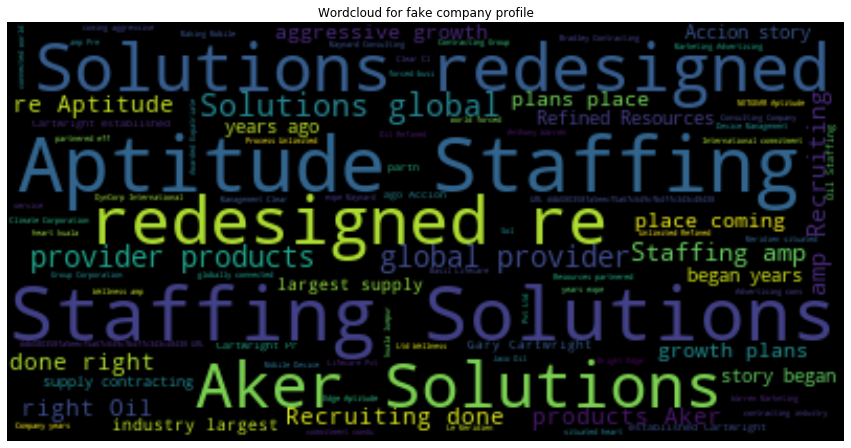

In [81]:
generate_wordcloud(fake_jobs, 'company_profile_tokenized', 'Wordcloud for fake company profile')

### Most of the fake jobs company's profiles are related to staffing

In [ ]:
generate_wordcloud(fake_jobs, 'requirements_tokenized', 'Wordcloud for description of fake job openings')

### For fake job openings, no specific educational qualifications are specified in requirements as in the case of real job openings (University degree, TEFL, TESOL certifications)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

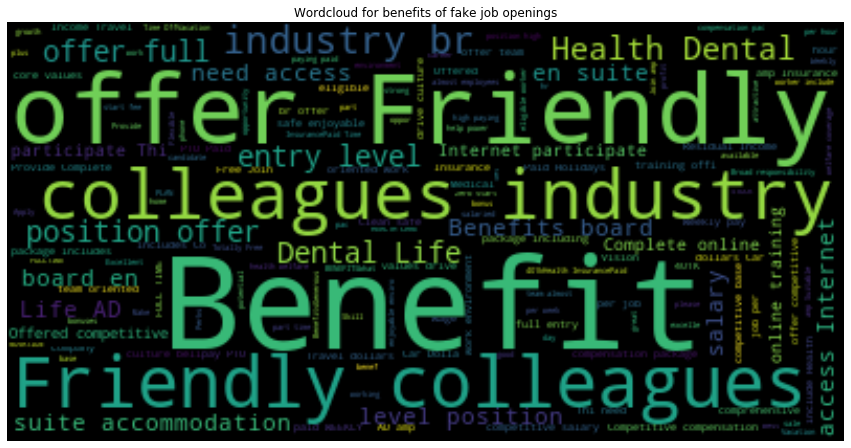

In [110]:
generate_wordcloud(fake_jobs, 'benefits_tokenized', 'Wordcloud for benefits of fake job openings')

### For fake job openings, benefits such as 'friendly colleagues' are used.

In [120]:
real_jobs.columns

Index(['job_id', 'title', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'country_code', 'city_name', 'company_profile_tokenized',
       'description_tokenized', 'requirements_tokenized',
       'benefits_tokenized'],
      dtype='object')

In [121]:
fake_jobs.columns

Index(['job_id', 'title', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'country_code', 'city_name', 'company_profile_tokenized',
       'description_tokenized', 'requirements_tokenized',
       'benefits_tokenized'],
      dtype='object')

In [122]:
processed_jobs_data = pd.concat([real_jobs, fake_jobs], ignore_index=True)

In [125]:
processed_jobs_data.shape

(17880, 23)

In [124]:
processed_jobs_data.head()

,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,required_education,industry,function,fraudulent,country_code,city_name,company_profile_tokenized,description_tokenized,requirements_tokenized,benefits_tokenized
0,1,Marketing Intern,Marketing,unknown,We re Food52 and we ve created a groundbreaki...,Food52 a fast growing James Beard Award winn...,Experience with content management systems a m...,unknown,0,1,...,unknown,unknown,Marketing,0,US,New York,"[We, Food52, created, groundbreaking, award, w...","[Food52, fast, growing, James, Beard, Award, w...","[Experience, content, management, systems, maj...",[]
1,2,Customer Service - Cloud Video Production,Success,unknown,90 Seconds the worlds Cloud Video Production ...,Organised Focused Vibrant Awesome Do you...,What we expect from you Your key responsibilit...,What you will get from usThrough being part of...,0,1,...,unknown,Marketing and Advertising,Customer Service,0,NZ,Auckland,"[90, Seconds, worlds, Cloud, Video, Production...","[Organised, Focused, Vibrant, Awesome, Do, pas...","[What, expect, Your, key, responsibility, comm...","[What, get, usThrough, part, 90, Seconds, team..."
2,3,Commissioning Machinery Assistant (CMA),unknown,unknown,Valor Services provides Workforce Solutions th...,Our client located in Houston is actively se...,Implement pre commissioning and commissioning ...,unknown,0,1,...,unknown,unknown,unknown,0,US,Wever,"[Valor, Services, provides, Workforce, Solutio...","[Our, client, located, Houston, actively, seek...","[Implement, pre, commissioning, commissioning,...",[]
3,4,Account Executive - Washington DC,Sales,unknown,Our passion for improving quality of life thro...,THE COMPANY ESRI Environmental Systems Rese...,EDUCATION Bachelor s or Master s in GIS busi...,Our culture is anything but corporate we have ...,0,1,...,Bachelor's Degree,Computer Software,Sales,0,US,Washington,"[Our, passion, improving, quality, life, geogr...","[THE, COMPANY, ESRI, Environmental, Systems, R...","[EDUCATION, Bachelor, Master, GIS, business, a...","[Our, culture, anything, corporate, collaborat..."
4,5,Bill Review Manager,unknown,unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE Itemization Review ManagerLOCATION ...,QUALIFICATIONS RN license in the State of Texa...,Full Benefits Offered,0,1,...,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Fort Worth,"[SpotSource, Solutions, LLC, Global, Human, Ca...","[JOB, TITLE, Itemization, Review, ManagerLOCAT...","[QUALIFICATIONS, RN, license, State, TexasDipl...","[Full, Benefits, Offered]"


In [127]:
processed_jobs_data.to_csv('data/processed_data.csv', index=False)